In [ ]:
from __future__ import print_function, division

In [ ]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

If you are new to this course and want more instructions on how to set up environement and all the libs (docker / windows / gpu / blas / etc.), you could read [vital instructions here](https://github.com/yandexdataschool/Practical_RL/issues/1#issue-202648393). 

Please make sure that your have bleeding edge versions of Theano, Lasagne and Agentnet.

# General purpose libs import

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from timeit import default_timer as timer

from IPython.core import  display

In [4]:
# if you have  GPU uncomment the line below 
%env THEANO_FLAGS=device=gpu1,floatX=float32

env: THEANO_FLAGS=device=gpu1,floatX=float32


Universal collection of a gentleman:

In [5]:
import gym

from agentnet.agent import Agent
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
from agentnet.memory import WindowAugmentation, LSTMCell, GRUCell
from agentnet.target_network import TargetNetwork
from agentnet.resolver import EpsilonGreedyResolver, ProbabilisticResolver
from agentnet.experiments.openai_gym.pool import EnvPool
from agentnet.learning import qlearning

from gym.wrappers import SkipWrapper
from gym.wrappers import TimeLimit

import theano
import theano.tensor as T 

import lasagne
from lasagne.layers import DenseLayer, Conv2DLayer, InputLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import batch_norm, get_all_params, get_output, reshape, concat, dropout
from lasagne.nonlinearities import rectify, leaky_rectify, elu, tanh, softmax

from tqdm import tqdm
from IPython.display import clear_output

[2017-04-18 20:20:34,105] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


# Helper function definitions

Downsample image, and crop it, showing only the most useful part of image. 

In [6]:
def make_env():
    env = gym.make("KungFuMaster-v0")
    env = (PreprocessImage(env, height=64, width=64, grayscale=True, crop=lambda img: img[60:-30, 7:]))
    return env 

Function for tracking performance while training 

In [7]:
def eval_and_plot(rewards, epoch_counter, pool):
    rewards[epoch_counter] = np.mean(pool.evaluate(n_games=N_EVAL_GAMES,record_video=False, verbose=False))
    info_string = "Epoch={}, mean_score={:.2f}"
    info_string = info_string.format(epoch_counter, np.mean(rewards[epoch_counter]))
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot([rewards[i] for i in sorted(rewards.keys())])
    plt.grid()
    plt.ylabel("Mean reward over evaluation games")
    plt.title(info_string)
    plt.show()

# Experiment setup
Here we basically just load the game and check that it works

In [8]:
env = gym.make('KungFuMaster-v0')

[2017-04-18 20:20:42,124] Making new env: KungFuMaster-v0


In [9]:
print(env.env.get_action_meanings())

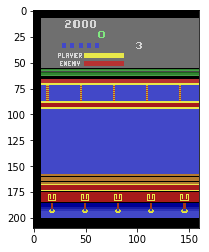

In [10]:
plt.imshow(env.reset())

[2017-04-18 20:20:42,485] Making new env: KungFuMaster-v0


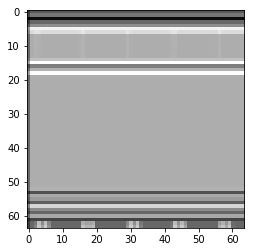

In [11]:
env = make_env()
plt.imshow(np.squeeze(env.reset()), cmap='gray')

# Global constants definition

All hyperparameters (except number of layers and neurons) are declared here as upper case letters along with global varaibles.

In [12]:
N_ACTIONS = env.action_space.n
OBS_SHAPE = env.observation_space.shape 
OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH = OBS_SHAPE

# These 4 constanst were shown to lead to nearly state of the art on kung-fu master game
N_SIMULTANEOUS_GAMES = 16  # this is also known as number of agents in exp_replay_pool
SEQ_LENGTH = 30

N_EVAL_GAMES = 2

N_FRAMES_IN_BUFFER = 4 # number of consequent frames to feed in CNN

# A2C with memory

In [13]:
observation_layer = InputLayer((None,) + OBS_SHAPE)
#prev_wnd = InputLayer([None, N_FRAMES_IN_BUFFER, OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH])
#new_wnd = WindowAugmentation(observation_layer, prev_wnd)
#wnd_reshape = reshape(new_wnd, [-1,  N_FRAMES_IN_BUFFER * OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH])
wnd_reshape = observation_layer

In [14]:
# TYPE YOUR CODE HERE
# provide the main body of the network : first three convolutional layers and dense one on top 
# you may want to change nonlinearity - feel free to do this 
# note that we have changed filter size here because of reduced image width and height compared to those in papers
conv1 = ConvLayer(wnd_reshape, num_filters=50, filter_size=5, stride=2, nonlinearity=elu)
conv2 = ConvLayer(conv1, num_filters=80, filter_size=5, stride=2, nonlinearity=elu)
conv3 = ConvLayer(conv2, num_filters=80, filter_size=3, stride=1, nonlinearity=elu)
dense = DenseLayer(conv3, num_units=512, nonlinearity=elu)

In [15]:
# YOUR CODE HERE
# define 256 neuron LSTM cell:
# - define two input layers each of n_lstm_cells (maybe 256 is a good baseline) neurons 
# - feed into `LSTMcell` this two layers and 
#   input layer (last `Dense` in case of A2C+LSTM) as additional third parameter

prev_gru_out = InputLayer((None, 256))
new_gru_out = GRUCell(prev_gru_out, dense)

prev_gru_out2 = InputLayer((None, 256))
new_gru_out2 = GRUCell(prev_gru_out2, new_gru_out)

prev_cell, prev_out = InputLayer((None, 256)), InputLayer((None, 256))
new_cell, new_out = LSTMCell(prev_cell, prev_out, new_gru_out2)

In [16]:
neck_layer = concat([dense, new_out]) # network neck 

In [17]:
# YOUR CODE HERE 
# define actors head as 
# - logits_layer – dense(neck) with nonlinearity=None 
# - policy_layer – softmax over logits_layer
logits_layer = DenseLayer(neck_layer, num_units=N_ACTIONS, nonlinearity=None)
policy_layer = NonlinearityLayer(logits_layer, nonlinearity=softmax)
action_layer = ProbabilisticResolver(policy_layer) 

In [18]:
# critic head
V_layer = DenseLayer(neck_layer, 1, nonlinearity=None)

target_net = TargetNetwork(V_layer)
target_V_layer = target_net.output_layers

In [19]:
# YOUR CODE HERE
# `observation_layers` is input layer to NN, as usual
# `policy_estimators` should include 1) logits_layer and 2) V_layer 
# `agent_states` is a dictionary of {new_value: old_value}. You should bother to update 
#    a) prev window (input buffer, prev_wnd)  b) previous LSTM cell state  c) output of LSTM cell 
# `action_layers` is action_layer, as usual : ) 
agent = Agent(observation_layers=observation_layer,
             policy_estimators=[logits_layer, V_layer, target_V_layer],
             agent_states={new_cell: prev_cell, new_out: prev_out, new_gru_out: prev_gru_out, new_gru_out2: prev_gru_out2},
             action_layers=action_layer)

In [20]:
# may need to adjust (increasing N_SIMULTANEOUS_GAMES is usually a good idea)
pool = EnvPool(agent, make_env, n_games=N_SIMULTANEOUS_GAMES) 
replay = pool.experience_replay

[2017-04-18 20:20:48,437] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,484] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,538] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,589] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,648] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,699] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,759] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,809] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,870] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,918] Making new env: KungFuMaster-v0
[2017-04-18 20:20:48,963] Making new env: KungFuMaster-v0
[2017-04-18 20:20:49,012] Making new env: KungFuMaster-v0
[2017-04-18 20:20:49,054] Making new env: KungFuMaster-v0
[2017-04-18 20:20:49,093] Making new env: KungFuMaster-v0
[2017-04-18 20:20:49,137] Making new env: KungFuMaster-v0
[2017-04-18 20:20:49,178] Making new env: KungFuMaster-v0


In [21]:
_, _, _, action_seq, (logits_seq, V_seq, target_V_seq) = agent.get_sessions( 
    replay, 
    session_length=SEQ_LENGTH, 
    experience_replay=True
)

In [22]:
# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev 
# for more info see (https://github.com/Theano/Theano/issues/2944 of 2015 year)

# logits_seq.shape is (batch_size, SEQ_LENGTH, N_ACTIONS)
logits_flat = logits_seq.reshape([-1, N_ACTIONS])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)

In [23]:
# get policy gradient
from agentnet.learning import a2c
elwise_actor_loss, elwise_critic_loss = a2c.get_elementwise_objective(
    policy=logpolicy_seq,
    treat_policy_as_logpolicy=True,
    state_values=V_seq[:,:,0],
    state_values_target=target_V_seq[:,:,0], 
    actions=replay.actions[0],
    rewards=replay.rewards / 10, 
    is_alive=replay.is_alive,
    gamma_or_gammas=0.99,
    n_steps=None,
    return_separate=True,
    
)
        
# add losses with magic numbers 
# (you can change them more or less harmlessly, this usually just makes learning faster/slower)
# actor and critic multipliers were selected guided by prior knowledge  
# entropy / regularization multipliers were tuned with logscale gridsearch
# NB: regularization affects exploration
reg_logits = T.mean(logits_seq ** 2)
reg_entropy = T.mean(T.sum(policy_seq * logpolicy_seq, axis=-1))
loss = 0.1 * elwise_actor_loss.mean() + 0.25 * elwise_critic_loss.mean() + 1e-3 * reg_entropy #+ 1e-3 * reg_logits

In [ ]:
# Compute weight updates, clip by norm for stability 
weights = lasagne.layers.get_all_params([V_layer, policy_layer], trainable=True)
grads = T.grad(loss, weights)
grads = lasagne.updates.total_norm_constraint(grads, 10)
updates = lasagne.updates.adam(grads, weights, learning_rate=0.0001)
train_step = theano.function([], loss, updates=updates)

# Train 

Current score(mean over 2) = 48500.000


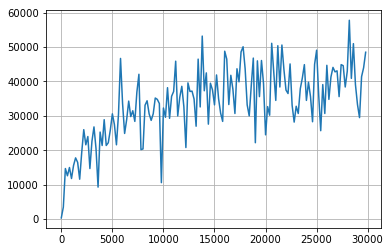

100%|██████████| 30000/30000 [16:23:02<00:00,  2.35s/it]  


In [ ]:
N_EPOCH = 30000

epoch_counter = 0
rewards = {}
for i in tqdm(range(N_EPOCH)):  
    
    pool.update(SEQ_LENGTH)
    loss = train_step()
    target_net.load_weights(0.01)

    if epoch_counter % 200 == 0:
        rewards[epoch_counter] = np.mean(pool.evaluate(record_video=False, 
                                                       n_games=N_EVAL_GAMES,
                                                       verbose=False))
        clear_output(True)
        print("Current score(mean over %i) = %.3f"%(N_EVAL_GAMES, np.mean(rewards[epoch_counter])))
        plt.plot(*zip(*sorted(rewards.items(),key=lambda t: t[0])))
        plt.grid()
        plt.show()
    
    epoch_counter += 1

In [ ]:
np.mean(pool.evaluate(record_video=False, n_games=10, verbose=False))

[2017-04-19 13:01:49,738] Making new env: KungFuMaster-v0
[2017-04-19 13:01:49,790] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-19 13:16:53,619] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/common/golovanov/records')


41800.0